# Technical Notebook: Buddy Bernhard and Irving Campbell

## TWO QUESTIONS (in no particular order)

### 1. It is said that after age 30, a player becomes "too old" for hockey.  But is that really true?  We form our null and alternative hypotheses to be:

#### H0: In comparing the point totals from the seasons when an NHL forward turns 30 and when that same NHL forward turns 31, there is either no difference or net positive change in points scored by the forward in the later season.

#### Ha: In comparing the point totals from the seasons when an NHL forward turns 30 and when that same NHL forward turns 31, there is a net negative change in points scored by the forward in the later season.

### 2. In the 2005-06 offseason, some changes were made to the rulebook.  It is known that these changes were made in an attempt to increase scoring in the league.   We form our null and alternative hypotheses to be:

#### H0: There is no statistically significant difference between teams' goals scored per game between the season before rule change (2003-2004) and the season after the rule change (2005-2006).

#### Ha: There is a statistically significant difference between teams' goals scored per game between the season before rule change (2003-2004) and the season after the rule change (2005-2006).

# QUESTION 1

##### Import appropriate packages:

In [1]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt  
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats as sm

##### We found two separate data sources: a skater statistics database downloadable at http://inalitic.com/datasets/nhl%20player%20data.html and a list of team statistics gotten from the NHL API.

In [2]:
df = pd.read_csv('skater_stats.csv', encoding='latin1')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Quick DataFrame cleanup.  Here we are looking at scoring points, so we
# are purposefully not looking at defensemen.  They are dropped from the
# DataFrame.

df = df.drop('Unnamed: 0', axis = 1)
d_men = df[df.Pos == " D "].index
df.drop(d_men, inplace=True)

df.head(10)

,Season,Player,Age,Tm,Pos,GP,G,GPG,A,PTS,...,SHA,S,S%,TOI,ATOI,BLK,HIT,FOwin,FOloss,FO%
0,2018,Justin Abdelkader,30.0,DET,LW,75,13,0.1733,22,35,...,-,110,12,"1,241",16:33,40.0,174.0,47.0,50.0,48.5
1,2018,Pontus Aberg,24.0,TOT,LW,53,4,0.0755,12,16,...,-,70,6,645,12:10,8.0,24.0,4.0,8.0,33.3
2,2018,Noel Acciari,26.0,BOS,C,60,10,0.1667,1,11,...,-,66,15,775,12:55,41.0,152.0,42.0,51.0,45.2
3,2018,Kenny Agostino,25.0,BOS,LW,5,-,0.0000,1,1,...,-,11,-,60,12:03,1.0,4.0,0.0,1.0,0.0
4,2018,Sebastian Aho,20.0,CAR,RW,78,29,0.3718,36,65,...,-,200,15,"1,398",17:55,17.0,65.0,78.0,94.0,45.3
8,2018,Michael Amadio,21.0,LAK,C,37,4,0.1081,4,8,...,-,28,14,345,9:19,9.0,18.0,74.0,96.0,43.5
9,2018,Josh Anderson,23.0,CBJ,RW,63,19,0.3016,11,30,...,-,188,10,"1,136",18:02,24.0,109.0,26.0,36.0,41.9
10,2018,Lias Andersson,19.0,NYR,C,7,1,0.1429,1,2,...,-,5,20,84,11:57,3.0,9.0,19.0,28.0,40.4
12,2018,Andy Andreoff,26.0,LAK,LW,45,3,0.0667,6,9,...,-,47,6,423,9:23,11.0,77.0,24.0,29.0,45.3
13,2018,Sven Andrighetto,24.0,COL,RW,50,8,0.1600,14,22,...,-,111,7,724,14:29,18.0,38.0,7.0,15.0,31.8


In [4]:
# Initializing variables
players_30 = []
df_30 = df.loc[df.Age == 30.0]
df_31 = df.loc[df.Age == 31.0]
df_35 = df.loc[df.Age == 35.0]
series_30 = df_30.Player
series_31 = df_31.Player
series_35 = df_35.Player
player_dict_30 = {}
player_dict_31 = {}
player_dict_35 = {}

# The csv includes asterisks after some player names.  The next two
# for loops remove these asterisks and add {name: [points, games]} as a
# new dictionary entry

for key30, value30 in series_30.iteritems():
    if value30 not in player_dict_30.keys():
        if value30.endswith('*'):
            player_dict_30[value30[:-1]] = df.loc[key30, ['PTS', 'GP']]
        else:
            player_dict_30[value30] = df.loc[key30, ['PTS', 'GP']]
            
for key31, value31 in series_31.iteritems():
    if value31 not in player_dict_31.keys():
        if value31.endswith('*'):
            player_dict_31[value31[:-1]] = df.loc[key31, ['PTS', 'GP']]
        else:
            player_dict_31[value31] = df.loc[key31, ['PTS', 'GP']]
            
for key35, value35 in series_35.iteritems():
    if value35 not in player_dict_35.keys():
        if value35.endswith('*'):
            player_dict_35[value35[:-1]] = df.loc[key35, ['PTS', 'GP']]
        else:
            player_dict_35[value35] = df.loc[key35, ['PTS', 'GP']]

In [5]:
# Initialize variables
dict_diff_3031 = {}
dict_diff_3035 = {}
ppg30 = 0
ppg31 = 0
ppg35 = 0

# Making all point totals int values.  Also correctly changes point
# values from ' -  ' to 0.
for key,value in player_dict_30.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)

for key,value in player_dict_31.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)
        
for key,value in player_dict_35.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)

# If the name exists in our 30-year-old player dictionary and our
# 31-year-old player dictionary, then we calculate points per game for
# each and enter {name: [ppg at 30, ppg at 31]} as a new dictionary entry.
# The same thing is done between 30- and 35-year-old players.
for key30, value30 in player_dict_30.items():
    if key30 in player_dict_31.keys():
        ppg30 = (value30.PTS/value30.GP)
        ppg31 = (player_dict_31[key30].PTS/player_dict_31[key30].GP)
        dict_diff_3031[key30] = [ppg30, ppg31]
        
    if key30 in player_dict_35.keys():
        ppg30 = (value30.PTS/value30.GP)
        ppg35 = (player_dict_35[key30].PTS/player_dict_35[key30].GP)
        dict_diff_3035[key30] = [ppg30, ppg35]

In [6]:
# Initialize values
dict_30_ppg_for_31 = []
dict_30_ppg_for_35 = []
dict_31_ppg = []
dict_35_ppg = []

# Make 30-year-old ppg list and 31-year-old ppg list for direct
# comparison
for key, value in dict_diff_3031.items():
    dict_30_ppg_for_31.append(value[0])
    dict_31_ppg.append(value[1])
    
for key, value in dict_diff_3035.items():
    dict_30_ppg_for_35.append(value[0])
    dict_35_ppg.append(value[1])

##### The next cell shows that there is a statistically significant decrease in points when comparing seasons when the forward is 30 and 31.  It also shows that there is a statistically significant decrease in points when comparing the forwards' 30- and 35-year old seasons.

In [7]:
# Paired t-test

print(f'Between ages 30 and 31, our paired t-test result is\n   {stats.ttest_rel(dict_30_ppg_for_31, dict_31_ppg)}')
print(f'Between ages 30 and 35, our paired t-test result is\n   {stats.ttest_rel(dict_30_ppg_for_35, dict_35_ppg)}')

Between ages 30 and 31, our paired t-test result is
   Ttest_relResult(statistic=7.556196786277496, pvalue=1.0173574094877106e-13)
Between ages 30 and 35, our paired t-test result is
   Ttest_relResult(statistic=11.84727847357693, pvalue=6.016046360150265e-27)


#### The next few cells define a fuction for the calculation of Cohen's d and the application of the function to the test statistics.  A discussion of the results follows below the cells.

In [8]:
# Quick Cohen's d implementation to check importance

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.average(x) - np.average(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [9]:
d_3031 = cohen_d(dict_30_ppg_for_31, dict_31_ppg)

In [10]:
d_3035 = cohen_d(dict_30_ppg_for_35, dict_35_ppg)

In [11]:
avg_3035 = (np.average(dict_30_ppg_for_35) - np.average(dict_35_ppg))*82
avg_3031 = (np.average(dict_30_ppg_for_31) - np.average(dict_31_ppg))*82

In [12]:
print(f'Cohen\'s d statistics between 30/31 year old forwards and 30/35 year old forwards:')
print(f'For 30 to 31: {round(d_3031, 4)}')
print(f'For 30 to 35: {round(d_3035, 4)}')
print()
print('The average points per game dropped extended over a whole 82 game season:')
print(f'From 30 to 31: {round(avg_3031, 4)}')
print(f'From 30 to 35: {round(avg_3035, 4)}')


Cohen's d statistics between 30/31 year old forwards and 30/35 year old forwards:
For 30 to 31: 0.164
For 30 to 35: 0.5488

The average points per game dropped extended over a whole 82 game season:
From 30 to 31: 4.237
From 30 to 35: 14.0411


#### The Cohen's d stats show that, while both of the t-tests showed a significance to the result of a net decrease in points, the importance of turning from 30 to 31 was pretty small ('small importance' is smaller than 0.2).   Turning from 30 to 35 showed a hgher importance level ('medium importance' is typically between 0.2 and 0.8)

#### This makes sense when looking at the amount of points *less* that a player would score over the course of their 31 and 35-year-old seasons.  The 31 year old loses an average of only 4 points over an entire season.  This is relatively small.  The 35 year old loses an average of 14 which, depending on the role he is being used for, may be quite important.

#### Below are a few boxplots showing the differences between the seasons.

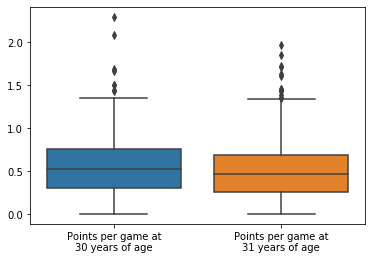

In [13]:
# Showing the tiny drop off in points per game.  The outliers are a 
# little more drastic, but outliers tend to be drastic anyway.
sns.boxplot( x=['Points per game at\n30 years of age', 'Points per game at\n31 years of age'], y=[dict_30_ppg_for_31, dict_31_ppg]);

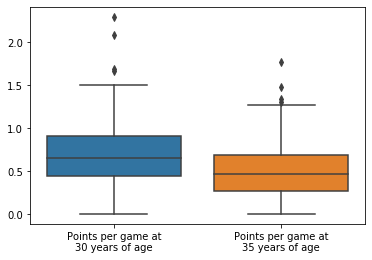

In [14]:
sns.boxplot( x=['Points per game at\n30 years of age', 'Points per game at\n35 years of age'], y=[dict_30_ppg_for_35, dict_35_ppg]);

### Conclusion for question 1:
#### We have enough here to reject the null hypothesis at an alpha of 0.05.  However, the Cohen's d statistic shows that, even though the change is significant, it isn't so important.  The exact drop in points per game is right around 1/20th of a point and for at least the better players, that dropoff would be pretty negligible.

#### As a comparison, the dropoff for the 35 year old (not the question asked, but an interesting statistic nonetheless) shows a dropoff that is more than three times as high, and even still...it is possible that even with that dropoff, a player may still be useful to an organization.

# QUESTION 2

#### Not the cleanest way to do this.  Given more time, we would remake this block into a function, so we can call it instead of having to copy and paste loops.

#### However, it is still effective.  These loops grab team data from the api and then create dictionaries with (key, value) pairs of (Team name, Goals per game) for each season.  This makes it easier to keep track of who scored what.

In [15]:
teamGoalsPerGame_04 = {}
teamGoalsPerGame_06 = {}
teamGoalsPerGame_07 = {}
teamGoalsPerGame_08 = {}
teamGoalsPerGame_09 = {}
teamGoalsPerGame_10 = {}
teamGoalsPerGame_11 = {}
teamGoalsPerGame_12 = {}

yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20032004'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()


for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_04[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20052006'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_06[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20062007'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_07[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20072008'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_08[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20082009'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_09[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20092010'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_10[name] = goalsPerGame
    

yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20102011'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_11[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20112012'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_12[name] = goalsPerGame

#### This cell is creating a list of the goals per game in team order.  The NHL API gave us data for these years where the team data was ordered the same way, so we could blindly iterate through the dictionaries without having to check the names.

In [16]:
gpg04 = []
gpg06 = []
gpg07 = []
gpg08 = []
gpg09 = []
gpg10 = []
gpg11 = []

for teamname in teamGoalsPerGame_04.keys():
    gpg04.append(teamGoalsPerGame_04[teamname])
    gpg06.append(teamGoalsPerGame_06[teamname])
    gpg07.append(teamGoalsPerGame_07[teamname])
    gpg08.append(teamGoalsPerGame_08[teamname])
    gpg09.append(teamGoalsPerGame_09[teamname])
    gpg10.append(teamGoalsPerGame_10[teamname])
    gpg11.append(teamGoalsPerGame_11[teamname])
 

#### The next two cells calculate the immediate change in goals per game per team, i.e. the change from the 03-04 season to the 05-06 season.  Clearly, both of these analyses resulted in significant statistical differences.  This represents a significant change between the 03-04 and 05-06 seasons, along with a significant change between the 03-04 season and the averages of the following five seasons.

##### Note: The 04-05 season was actually never played due to a lockout by the players union.

In [17]:
# Paired t-test
stats.ttest_rel(gpg04, gpg06)

Ttest_relResult(statistic=-8.430935861838218, pvalue=2.7254557252413516e-09)

In [18]:
meanofnextfiveseasons = np.array(gpg06)+np.array(gpg07)+np.array(gpg08)+np.array(gpg09)+np.array(gpg10)
meanofnextfiveseasons = meanofnextfiveseasons/5
stats.ttest_rel(gpg04, meanofnextfiveseasons)

Ttest_relResult(statistic=-5.258912208578422, pvalue=1.2351911502708235e-05)

#### The cell below shows a graph of individual teams' goals per game across seven seasons.  The lighter blue boxplot represents the season before the changes were implemented, while the darker blue boxplots represent the seasons after.  Using this result as an eye test, we can see that the seasons after the rule change showed higher goal numbers but may also indicate a downward trend.

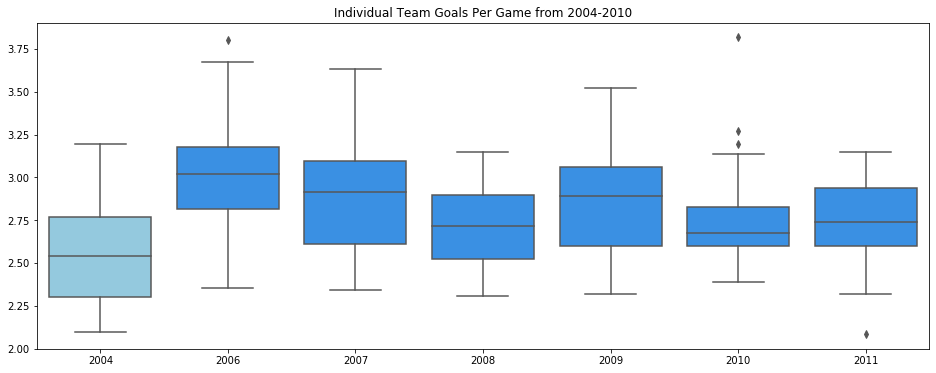

In [19]:
my_pal = {'2004': 'skyblue', '2006': 'dodgerblue', '2007': 'dodgerblue', '2008': 'dodgerblue', '2009': 'dodgerblue', '2010': 'dodgerblue', '2011': 'dodgerblue'}
plt.figure(figsize=(16, 6))
plt.title('Individual Team Goals Per Game from 2004-2010')
sns.boxplot( x=['2004', '2006', '2007', '2008', '2009', '2010', '2011'], y=[gpg04, gpg06, gpg07, gpg08, gpg09, gpg10, gpg11], palette=my_pal);

#### The next cells show the Cohen's d statistics for the two comparison analyses.  The numbers are high and represent a change of high importance for both analyses.  So, not only are these changes significant but they mark a real and lartge differences in NHL goal scoring.

In [20]:
gpg0406 = cohen_d(gpg04, gpg06)
gpg0410 = cohen_d(gpg04, meanofnextfiveseasons)

print('Cohen\'s d statistics:')
print(f'Between 03-04 and 05-06: {round(gpg0406, 4)}')
print(f'Between 03-04 and an average of the next five seasons: {round(gpg0410, 4)}')

Cohen's d statistics:
Between 03-04 and 05-06: -1.4787
Between 03-04 and an average of the next five seasons: -1.1382


### Conclusion for question 2:
#### We have enough here to reject the null hypothesis at an alpha of 0.05.  The league saw a sigificant increase in individual teams' goals per game between the seasons directly before and after the rule change.  The Cohen's d statistic of ~1.48 also represents a change of high importance ('large importance' typically classified at higher than 0.8).

#### As a comparison, we made a comparison between the season before the change and an average of the five seasons afterwards.  With this idea, we were hoping to capture any regression back towards the mean.  However, the t statistic was still significant and the Cohen's d variable was still large.  If there is a change here, it is not enough to state that we fail to reject the null hypothesis.

# MOVING FORWARD

#### For question 1, we can find other age ranges where declines begin to appear.  Defensemen are not known for scoring so they are not included in this analysis, but a similar analysis of defensemen using a different statistic (e.g, +/- or shots blocked) could be implemented.

#### For question 2, we can run a repeated measures ANOVA to further find differences between seasons, but we were unable to perform it here due to lack of time.  